In [6]:
import pandas as pd
from imblearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


# 1- Text-only

In [7]:

def logistic_func(df):

    # keep test_set apart
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['bsa_dummy'], shuffle=True,
                                             random_state=0)
    X_train = df_train['motivation']
    y_train = df_train['bsa_dummy']
    X_test = df_test['motivation']
    y_test = df_test['bsa_dummy']

 
    stopword_list = list(stopwords.words('Dutch'))

    pipe = make_pipeline(TfidfVectorizer(lowercase=True, stop_words=stopword_list), 
                        LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced'))
    scores = cross_val_score(pipe, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()



5-fold cross validation scores: [0.64117092 0.61945231 0.6421152  0.61850803 0.63833805]
average of 5-fold cross validation scores: 0.6319169027384326
Accuracy for SVM on test_set: 0.6260623229461756
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1312
           1       0.34      0.47      0.39       453

    accuracy                           0.63      1765
   macro avg       0.56      0.57      0.56      1765
weighted avg       0.67      0.63      0.64      1765



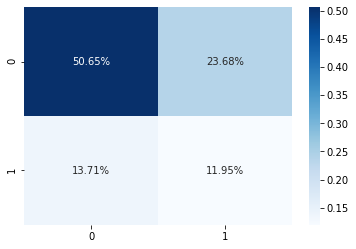

In [8]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')
# df.dropna(subset=['bsa_dummy', 'motivation'], inplace=True)
df = df.fillna(method='ffill')

logistic_func(df)


# 1-1- Text-only: feature selection

In [10]:
def logistic_text_featureselection(df):

    # keep test_set apart
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['bsa_dummy'], shuffle=True,
                                             random_state=0)
    X_train = df_train['motivation']
    y_train = df_train['bsa_dummy']
    X_test = df_test['motivation']
    y_test = df_test['bsa_dummy']

 
    stopword_list = list(stopwords.words('Dutch'))

    pipe = make_pipeline(TfidfVectorizer(lowercase=True, stop_words=stopword_list),
                         SelectFromModel(LinearSVC(penalty="l1", dual=False)),
                         LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced'))
    scores = cross_val_score(pipe, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()



5-fold cross validation scores: [0.61945231 0.60623229 0.62417375 0.59206799 0.61095373]
average of 5-fold cross validation scores: 0.6105760151085929
Accuracy for SVM on test_set: 0.6135977337110482
              precision    recall  f1-score   support

           0       0.79      0.65      0.71      1312
           1       0.34      0.51      0.41       453

    accuracy                           0.61      1765
   macro avg       0.56      0.58      0.56      1765
weighted avg       0.68      0.61      0.63      1765



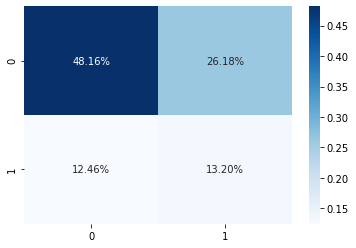

In [11]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')
# df.dropna(subset=['bsa_dummy', 'motivation'], inplace=True)
df = df.fillna(method='ffill')
logistic_text_featureselection(df)

# 2- Initial numeric features

In [33]:
   
def logistic_initial_features(df):  
    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA']
    target = df['bsa_dummy']
    df1 = df[categorical_features]
    df2 = df[numeric_features]
    df = pd.concat([df1, df2], axis=1)
    df = pd.concat([df, target], axis=1)

    # keep test_set apart
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['bsa_dummy'], shuffle=True,
                                             random_state=0)

    X_train = df_train.loc[:,df_train.columns !='bsa_dummy']
    y_train = df_train['bsa_dummy']
    X_test = df_test.loc[:,df_test.columns !='bsa_dummy']
    y_test = df_test['bsa_dummy']
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

 
    pipe = make_pipeline(preprocessor,                         
                         LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced'))
    
    scores = cross_val_score(pipe, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    
    importance = pipe.steps[1][1].coef_
    feature_names = numeric_features + categorical_features

    # Zip feature importance and feature names in the format of dictionary
    coef_dict = {}
    for coef, feat in zip(pipe.steps[1][1].coef_[0, :], feature_names):
        coef_dict[feat] = coef

    # Sort feature_importance values
    coef_dict = dict(sorted(coef_dict.items(), key=lambda item: item[1]))

    # Turn dictionary to series
    feature_importance = pd.Series(list(coef_dict.values()), index=coef_dict.keys())
    print(feature_importance)

    # Plot feature importance
    feature_importance.plot.barh(figsize=(5, 10))
    plt.show()


    
    

5-fold cross validation scores: [0.62228517 0.62700661 0.61000944 0.61567517 0.62417375]
average of 5-fold cross validation scores: 0.6198300283286119
Accuracy for SVM on test_set: 0.6090651558073654
              precision    recall  f1-score   support

           0       0.84      0.59      0.69      1312
           1       0.36      0.68      0.47       453

    accuracy                           0.61      1765
   macro avg       0.60      0.63      0.58      1765
weighted avg       0.72      0.61      0.63      1765



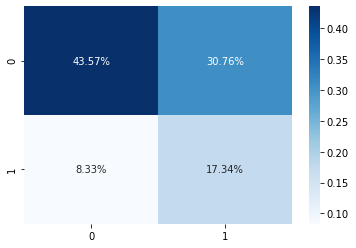

HSGPA                 -0.477629
year                  -0.346052
previously_enrolled   -0.185486
cohort                -0.134109
gender                -0.002527
program                0.048550
multiple_requests      0.055146
interest               0.055158
age                    0.113394
prior_educ             0.145602
field                  0.149371
ase                    0.308683
dtype: float64


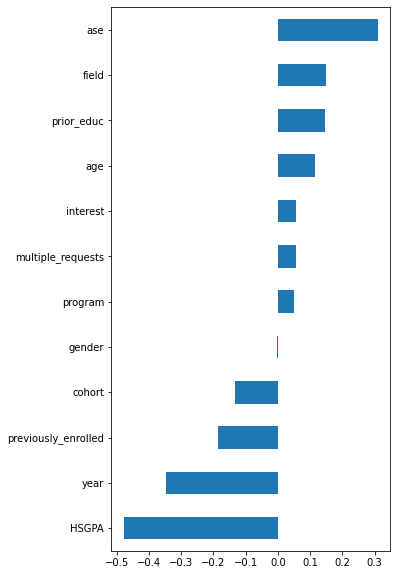

In [34]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')

logistic_initial_features(df)

# 3- Added features + initial features- only numeric and categorical

In [15]:
 
def logistic_all_nontext_features(df):
    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA', 'WC', 'WPS', 'Sixltr',
                            'Dic', 'funct', 'pronoun', 'ppron', 'i',
                            'we', 'you', 'shehe', 'they', 'ipron',
                            'article', 'verb', 'auxverb', 'past', 'present',
                            'future', 'adverb', 'preps', 'conj', 'negate',
                            'quant', 'number', 'swear', 'social', 'family',
                            'friend', 'humans', 'affect', 'posemo', 'negemo',
                            'anx', 'anger', 'sad', 'cogmech', 'insight',
                            'cause', 'discrep', 'tentat', 'certain', 'inhib',
                            'incl', 'excl', 'percept', 'see', 'hear',
                            'feel', 'bio', 'body', 'health', 'sexual',
                            'ingest', 'relativ', 'motion', 'space', 'time',
                            'work', 'achieve', 'leisure', 'home', 'money',
                            'relig', 'death', 'assent', 'nonfl', 'filler',
                            'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                            'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                            'Quote', 'Apostro', 'Parenth', 'OtherP', 'count_punct',
                            'count_stopwords', 'nr_token', 'nr_adj', 'nr_noun', 'nr_verb',
                            'nr_number', 'topic1', 'topic2', 'topic3', 'topic4',
                            'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
                            'topic10', 'topic11', 'topic12', 'topic13', 'topic14',
                            'topic15']

    # Change object (string) type of features to float
    change_type = ['WPS', 'Sixltr',
                       'Dic', 'funct', 'pronoun', 'ppron', 'i',
                       'we', 'you', 'shehe', 'they', 'ipron',
                       'article', 'verb', 'auxverb', 'past', 'present',
                       'future', 'adverb', 'preps', 'conj', 'negate',
                       'quant', 'number', 'swear', 'social', 'family',
                       'friend', 'humans', 'affect', 'posemo', 'negemo',
                       'anx', 'anger', 'sad', 'cogmech', 'insight',
                       'cause', 'discrep', 'tentat', 'certain', 'inhib',
                       'incl', 'excl', 'percept', 'see', 'hear',
                       'feel', 'bio', 'body', 'health', 'sexual',
                       'ingest', 'relativ', 'motion', 'space', 'time',
                       'work', 'achieve', 'leisure', 'home', 'money',
                       'relig', 'death', 'assent', 'nonfl', 'filler',
                       'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                       'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                       'Quote', 'Apostro', 'Parenth', 'OtherP']
    df[change_type] = df[change_type].apply(lambda x: x.str.replace(',', '.'))
    df[change_type] = df[change_type].astype(float).fillna(0.0)

    target = df['bsa_dummy']

    df1 = df[categorical_features]
    df2 = df[numeric_features]
    df = pd.concat([df1, df2], axis=1)
    df = pd.concat([df, target], axis=1)

    # keep test_set apart
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['bsa_dummy'], shuffle=True,
                                             random_state=0)

    X_train = df_train.loc[:,df_train.columns !='bsa_dummy']
    y_train = df_train['bsa_dummy']
    X_test = df_test.loc[:,df_test.columns !='bsa_dummy']
    y_test = df_test['bsa_dummy']
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

 
    pipe = make_pipeline(preprocessor,                         
                         LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced'))
    
    scores = cross_val_score(pipe, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()



5-fold cross validation scores: [0.65061379 0.60906516 0.64494806 0.60623229 0.63833805]
average of 5-fold cross validation scores: 0.6298394711992447
Accuracy for SVM on test_set: 0.6198300283286119
              precision    recall  f1-score   support

           0       0.83      0.61      0.71      1312
           1       0.36      0.64      0.46       453

    accuracy                           0.62      1765
   macro avg       0.60      0.63      0.58      1765
weighted avg       0.71      0.62      0.64      1765



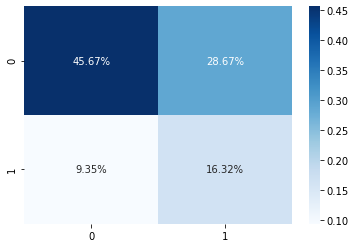

In [16]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')

logistic_all_nontext_features(df)

# 4- Text + Initial non-textual features

In [17]:
def logistic_text_initial_features(df):
    stopword_list = list(stopwords.words('Dutch'))

    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA']
    text_features = ['motivation']
    
    target = df['bsa_dummy']
    
    get_text_data = FunctionTransformer(lambda x: x['motivation'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_features], validate=False)
    get_categorical_data = FunctionTransformer(lambda x: x[categorical_features], validate=False)

    process_and_join_features = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())

            ])),
            ('categorical_features', Pipeline([
                ('selector', get_categorical_data),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))

            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(lowercase=True, stop_words=stopword_list))
            ]))
        ])),


        ('clf', LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced'))
    ])
    
  
    
    df = df.dropna()
    text = df['motivation']
    num = df[numeric_features]
    cat = df[categorical_features]
    df_features =pd.concat([text,num], axis=1)
    df_features =pd.concat([df_features,cat], axis=1)

    
    X_train, X_val, y_train, y_val = train_test_split(df_features, df['bsa_dummy'], stratify=df['bsa_dummy'], test_size=0.25, random_state=0)
    
 
    process_and_join_features.fit(X_train, y_train)
#     predictions_lt = process_and_join_features.predict(X_val)
    
    scores = cross_val_score(process_and_join_features, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    process_and_join_features.fit(X_train, y_train)
    predictions = process_and_join_features.predict(X_val)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_val, predictions))
    cm = confusion_matrix(y_val, predictions)
    print(classification_report(y_val, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()


5-fold cross validation scores: [0.66194523 0.65627951 0.65816808 0.66477809 0.67044381]
average of 5-fold cross validation scores: 0.6623229461756374
Accuracy for SVM on test_set: 0.6402266288951841
              precision    recall  f1-score   support

           0       0.82      0.66      0.73      1312
           1       0.37      0.57      0.45       453

    accuracy                           0.64      1765
   macro avg       0.59      0.62      0.59      1765
weighted avg       0.70      0.64      0.66      1765



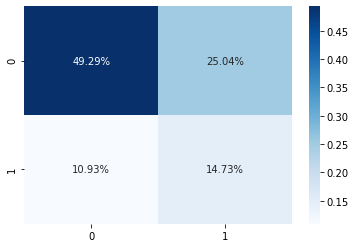

In [18]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')


logistic_text_initial_features(df)

# 5- Text + all non-textual features

In [19]:
def logistic_all_features(df):
    stopword_list = list(stopwords.words('Dutch'))

    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA', 'WC', 'WPS', 'Sixltr',
                        'Dic', 'funct', 'pronoun', 'ppron', 'i',
                        'we', 'you', 'shehe', 'they', 'ipron',
                        'article', 'verb', 'auxverb', 'past', 'present',
                        'future', 'adverb', 'preps', 'conj', 'negate',
                        'quant', 'number', 'swear', 'social', 'family',
                        'friend', 'humans', 'affect', 'posemo', 'negemo',
                        'anx', 'anger', 'sad', 'cogmech', 'insight',
                        'cause', 'discrep', 'tentat', 'certain', 'inhib',
                        'incl', 'excl', 'percept', 'see', 'hear',
                        'feel', 'bio', 'body', 'health', 'sexual',
                        'ingest', 'relativ', 'motion', 'space', 'time',
                        'work', 'achieve', 'leisure', 'home', 'money',
                        'relig', 'death', 'assent', 'nonfl', 'filler',
                        'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                        'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                        'Quote', 'Apostro', 'Parenth', 'OtherP', 'count_punct',
                        'count_stopwords', 'nr_token', 'nr_adj', 'nr_noun', 'nr_verb',
                        'nr_number', 'topic1', 'topic2', 'topic3', 'topic4',
                        'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
                        'topic10', 'topic11', 'topic12', 'topic13', 'topic14',
                        'topic15']
    text_features = ['motivation']
    
    target = df['bsa_dummy']
    
    get_text_data = FunctionTransformer(lambda x: x['motivation'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_features], validate=False)
    get_categorical_data = FunctionTransformer(lambda x: x[categorical_features], validate=False)

    process_and_join_features = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())

            ])),
            ('categorical_features', Pipeline([
                ('selector', get_categorical_data),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))

            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(lowercase=True, stop_words=stopword_list)),
                ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False)))
            ]))
        ])),


        ('clf', LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced'))
    ])
    
  
    
    df = df.dropna()
    text = df['motivation']
    num = df[numeric_features]
    cat = df[categorical_features]
    df_features =pd.concat([text,num], axis=1)
    df_features =pd.concat([df_features,cat], axis=1)

    
    X_train, X_val, y_train, y_val = train_test_split(df_features, df['bsa_dummy'], stratify=df['bsa_dummy'], test_size=0.25, random_state=0)
    
 
    process_and_join_features.fit(X_train, y_train)
#     predictions_lt = process_and_join_features.predict(X_val)
    
    scores = cross_val_score(process_and_join_features, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    process_and_join_features.fit(X_train, y_train)
    predictions = process_and_join_features.predict(X_val)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_val, predictions))
    cm = confusion_matrix(y_val, predictions)
    print(classification_report(y_val, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()


5-fold cross validation scores: [0.66288952 0.64400378 0.64778093 0.6421152  0.6572238 ]
average of 5-fold cross validation scores: 0.6508026440037772
Accuracy for SVM on test_set: 0.6413597733711048
              precision    recall  f1-score   support

           0       0.82      0.66      0.73      1312
           1       0.37      0.59      0.46       453

    accuracy                           0.64      1765
   macro avg       0.60      0.62      0.59      1765
weighted avg       0.71      0.64      0.66      1765



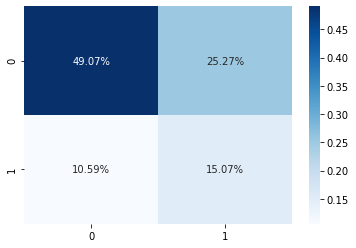

In [20]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')
change_type = ['WPS', 'Sixltr',
                   'Dic', 'funct', 'pronoun', 'ppron', 'i',
                   'we', 'you', 'shehe', 'they', 'ipron',
                   'article', 'verb', 'auxverb', 'past', 'present',
                   'future', 'adverb', 'preps', 'conj', 'negate',
                   'quant', 'number', 'swear', 'social', 'family',
                   'friend', 'humans', 'affect', 'posemo', 'negemo',
                   'anx', 'anger', 'sad', 'cogmech', 'insight',
                   'cause', 'discrep', 'tentat', 'certain', 'inhib',
                   'incl', 'excl', 'percept', 'see', 'hear',
                   'feel', 'bio', 'body', 'health', 'sexual',
                   'ingest', 'relativ', 'motion', 'space', 'time',
                   'work', 'achieve', 'leisure', 'home', 'money',
                   'relig', 'death', 'assent', 'nonfl', 'filler',
                   'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                   'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                   'Quote', 'Apostro', 'Parenth', 'OtherP']
df[change_type] = df[change_type].apply(lambda x: x.str.replace(',', '.'))
df[change_type] = df[change_type].astype(float).fillna(0.0)
logistic_all_features(df)

# 6 - Text + all features excluding LIWC

In [23]:
def logistic_all_without_liwc_features(df):
    stopword_list = list(stopwords.words('Dutch'))

    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA', 'nr_token', 'nr_adj', 'nr_noun', 'nr_verb',
                        'nr_number', 'topic1', 'topic2', 'topic3', 'topic4',
                        'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
                        'topic10', 'topic11', 'topic12', 'topic13', 'topic14',
                        'topic15']
    text_features = ['motivation']
    
    target = df['bsa_dummy']
    
    get_text_data = FunctionTransformer(lambda x: x['motivation'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_features], validate=False)
    get_categorical_data = FunctionTransformer(lambda x: x[categorical_features], validate=False)

    process_and_join_features = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())

            ])),
            ('categorical_features', Pipeline([
                ('selector', get_categorical_data),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))

            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(lowercase=True, stop_words=stopword_list)),
                ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False)))
            ]))
        ])),


        ('clf', LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', penalty='l2', class_weight='balanced'))
    ])
    
  
    
    df = df.dropna()
    text = df['motivation']
    num = df[numeric_features]
    cat = df[categorical_features]
    df_features =pd.concat([text,num], axis=1)
    df_features =pd.concat([df_features,cat], axis=1)

    
    X_train, X_val, y_train, y_val = train_test_split(df_features, df['bsa_dummy'], stratify=df['bsa_dummy'], test_size=0.25, random_state=0)
    
 
    process_and_join_features.fit(X_train, y_train)
#     predictions_lt = process_and_join_features.predict(X_val)
    
    scores = cross_val_score(process_and_join_features, X_train, y_train, cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    process_and_join_features.fit(X_train, y_train)
    predictions = process_and_join_features.predict(X_val)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_val, predictions))
    cm = confusion_matrix(y_val, predictions)
    print(classification_report(y_val, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()


5-fold cross validation scores: [0.65911237 0.65250236 0.66194523 0.64872521 0.66100094]
average of 5-fold cross validation scores: 0.656657223796034
Accuracy for SVM on test_set: 0.6220963172804532
              precision    recall  f1-score   support

           0       0.81      0.64      0.71      1312
           1       0.36      0.58      0.44       453

    accuracy                           0.62      1765
   macro avg       0.59      0.61      0.58      1765
weighted avg       0.70      0.62      0.64      1765



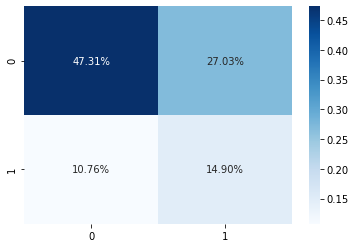

In [24]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')

logistic_all_without_liwc_features(df)